# 300 Autoencoder Tutorial Notebook

This Notebook should give a quick introduction to how Autoencoders work. It will be trained on the MNIST handwritten digit dataset. The code is dependant on keras, matplotlib and numpy while using Tensorflow 2.X.


## Sources:
MNIST Database:
 - http://yann.lecun.com/exdb/mnist/

Papers:
 - https://arxiv.org/abs/1805.00251
 - https://arxiv.org/abs/1805.09730

Tutorials:
 - https://blog.keras.io/building-autoencoders-in-keras.html
 
 
 ## Training the Autoencoder
 
 The Autoencoder is composed of an encoder and a decoder half. Once an MNIST image is fed into the network, it is compressed to the *feature_map* layer, which maps the small input space to the generated MNIST images. The image fed into the autoencoder and outputted by it should be identical. The loss function penalizes the network when there is a big difference.
 
 <img src="Autoencoder MNIST Explanation.png">

(60000, 28, 28, 1)
(60000,)


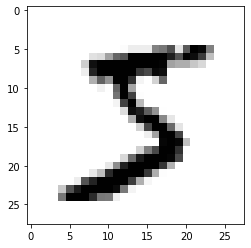

In [6]:
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, InputLayer, LeakyReLU
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt



mnist = tf.keras.datasets.mnist

# Expand Dimensions to 3D to add one for the color channel of black and white: expand_dims(train_images, axis=-1)
# Normalize the image by dividing by 255 --> faster convergence
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = np.expand_dims(train_images, axis=-1) / 255.0, np.expand_dims(train_images, axis=-1) / 255.0


# Examples
# Shape is (60000, 28, 28, 1) for 60 000 images with dimensions 28 x 28 and 1 color channel (black and white)
print(train_images.shape)
print(train_labels.shape)

plt.imshow(train_images[0, :, :, 0], cmap='gray_r')

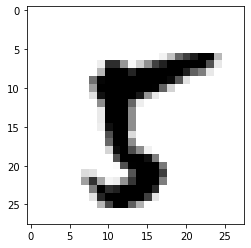

In [7]:
# Helper function to create a batch
# It returns identical image pairs: *train_images* = *y_train_images*

# Sample minibatch from MNIST
def get_MNIST_samples(n_samples):
    # Pick new image samples from dataset
    # Pick random images to help with gradient descent
    image_samples = np.zeros((n_samples, 28, 28, 1))

    for i in range(0, n_samples):
        index = random.randint(0, 59999)
        image_samples[i] = train_images[index]

    # Both x and y are the same, since the autoencoder should produce the same image
    return image_samples, image_samples


# Examples
train_images_example, y_train_images_example = get_MNIST_samples(32)
plt.imshow(train_images_example[0, :, :, 0], cmap='gray_r')

In [8]:
# Define the Encoder, Decoder and the whole Autoencoder with Keras

# Build the encoder
def build_encoder():
    model = Sequential()

    model.add(Flatten(input_shape=(28, 28, 1)))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(2))
    model.add(LeakyReLU(alpha=0.2))

    return model


# Build the decoder
def build_decoder():
    model = Sequential()

    model.add(InputLayer(input_shape=2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    # activation='sigmoid' to get the values for the image between 0 and 1
    model.add(Dense(784, activation='sigmoid'))

    # None ist the batch size, 28 x 28 is the input image with 1 color channel
    model.add(Reshape((28, 28, 1)))

    return model


# Build the Autoencoder by combining the encoder and the decoder
def build_autoencoder(encoder, decoder):
    model = Sequential()

    model.add(encoder)
    model.add(decoder)

    # Loss function and optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [9]:
# Train the model

def train(encoder, decoder, autoencoder_model, n_epochs=100, n_batch=32):
    batches_per_epoch = int(60000 / n_batch)

    for epoch in range(0, n_epochs):
        for batch in range(0, batches_per_epoch):

            # Get MNIST images
            train_images, y_train_images = get_MNIST_samples(n_batch)

            # Run a batch through the autoencoder_model
            autoencoder_loss = autoencoder_model.train_on_batch(train_images, y_train_images)

            print('Epoch: ', epoch, '   Batch Number: ', batch, ' / ', batches_per_epoch, '   Autoencoder loss: ',  autoencoder_loss)

            # Save values and models
            if batch % 1800 == 0:
                # Save the generator and discriminator
                encoder.save('encoder.h5', )
                decoder.save('decoder.h5')
                autoencoder_model.save('autoencoder_model.h5')

                # Predict some images to read out the progress of the autoencoder
                autoencoder_model_output = autoencoder_model.predict(train_images)

                # Print generated_images with matplotlib
                # First the images from train_images, then autoencoder_moder_output
                for i in range(1, 5):
                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 3 * (i - 1))
                    if i == 1:
                        plt.title("MNIST")
                    # Plot raw pixel data
                    plt.imshow(train_images[i, :, :, 0], cmap='gray_r')

                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 1 + 3 * (i - 1))
                    if i == 1:
                        plt.title("Generated")
                    # Plot raw pixel data
                    plt.imshow(autoencoder_model_output[i, :, :, 0], cmap='gray_r')

                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 2 + 3 * (i - 1))
                    if i == 1:
                        plt.title("MNIST")
                    # Plot raw pixel data
                    plt.imshow(train_images[i + 4, :, :, 0], cmap='gray_r')

                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 3 + 3 * (i - 1))
                    if i == 1:
                        plt.title("Generated")
                    # Plot raw pixel data
                    plt.imshow(autoencoder_model_output[i + 4, :, :, 0], cmap='gray_r')

                plt.savefig('plot  epoch ' + '%02d' % epoch + '  batch ' + '%05d' % batch + '.png', dpi=600)
                plt.close()

In [ ]:
# Start training cycle

# Build the autoencoder
encoder = build_encoder()
decoder = build_decoder()
autoencoder_model = build_autoencoder(encoder, decoder)

# Train Autoencoder
train(encoder, decoder, autoencoder_model)

Epoch:  0    Batch Number:  0  /  1875    Autoencoder loss:  0.6931300163269043
Epoch:  0    Batch Number:  1  /  1875    Autoencoder loss:  0.692430317401886
Epoch:  0    Batch Number:  2  /  1875    Autoencoder loss:  0.6913483142852783
Epoch:  0    Batch Number:  3  /  1875    Autoencoder loss:  0.6891655325889587
Epoch:  0    Batch Number:  4  /  1875    Autoencoder loss:  0.6857895851135254
Epoch:  0    Batch Number:  5  /  1875    Autoencoder loss:  0.6800934672355652
Epoch:  0    Batch Number:  6  /  1875    Autoencoder loss:  0.670768678188324
Epoch:  0    Batch Number:  7  /  1875    Autoencoder loss:  0.6567944288253784
Epoch:  0    Batch Number:  8  /  1875    Autoencoder loss:  0.6388950943946838
Epoch:  0    Batch Number:  9  /  1875    Autoencoder loss:  0.6063756942749023
Epoch:  0    Batch Number:  10  /  1875    Autoencoder loss:  0.575364887714386
Epoch:  0    Batch Number:  11  /  1875    Autoencoder loss:  0.526074230670929
Epoch:  0    Batch Number:  12  /  1875   

Epoch:  0    Batch Number:  112  /  1875    Autoencoder loss:  0.25927504897117615
Epoch:  0    Batch Number:  113  /  1875    Autoencoder loss:  0.26446717977523804
Epoch:  0    Batch Number:  114  /  1875    Autoencoder loss:  0.26477599143981934
Epoch:  0    Batch Number:  115  /  1875    Autoencoder loss:  0.2692669630050659
Epoch:  0    Batch Number:  116  /  1875    Autoencoder loss:  0.2703609764575958
Epoch:  0    Batch Number:  117  /  1875    Autoencoder loss:  0.2699694335460663
Epoch:  0    Batch Number:  118  /  1875    Autoencoder loss:  0.25735223293304443
Epoch:  0    Batch Number:  119  /  1875    Autoencoder loss:  0.27180877327919006
Epoch:  0    Batch Number:  120  /  1875    Autoencoder loss:  0.2696841359138489
Epoch:  0    Batch Number:  121  /  1875    Autoencoder loss:  0.26790082454681396
Epoch:  0    Batch Number:  122  /  1875    Autoencoder loss:  0.2547975182533264
Epoch:  0    Batch Number:  123  /  1875    Autoencoder loss:  0.2552618980407715
Epoch:  0 

Epoch:  0    Batch Number:  218  /  1875    Autoencoder loss:  0.2447180598974228
Epoch:  0    Batch Number:  219  /  1875    Autoencoder loss:  0.24957045912742615
Epoch:  0    Batch Number:  220  /  1875    Autoencoder loss:  0.2609799802303314
Epoch:  0    Batch Number:  221  /  1875    Autoencoder loss:  0.24464687705039978
Epoch:  0    Batch Number:  222  /  1875    Autoencoder loss:  0.26076897978782654
Epoch:  0    Batch Number:  223  /  1875    Autoencoder loss:  0.23708997666835785
Epoch:  0    Batch Number:  224  /  1875    Autoencoder loss:  0.2646907567977905
Epoch:  0    Batch Number:  225  /  1875    Autoencoder loss:  0.24214069545269012
Epoch:  0    Batch Number:  226  /  1875    Autoencoder loss:  0.23920153081417084
Epoch:  0    Batch Number:  227  /  1875    Autoencoder loss:  0.21250911056995392
Epoch:  0    Batch Number:  228  /  1875    Autoencoder loss:  0.2468346208333969
Epoch:  0    Batch Number:  229  /  1875    Autoencoder loss:  0.23146745562553406
Epoch:  

Epoch:  0    Batch Number:  324  /  1875    Autoencoder loss:  0.23688502609729767
Epoch:  0    Batch Number:  325  /  1875    Autoencoder loss:  0.22940470278263092
Epoch:  0    Batch Number:  326  /  1875    Autoencoder loss:  0.2150745391845703
Epoch:  0    Batch Number:  327  /  1875    Autoencoder loss:  0.21554355323314667
Epoch:  0    Batch Number:  328  /  1875    Autoencoder loss:  0.22716040909290314
Epoch:  0    Batch Number:  329  /  1875    Autoencoder loss:  0.23993909358978271
Epoch:  0    Batch Number:  330  /  1875    Autoencoder loss:  0.2386777251958847
Epoch:  0    Batch Number:  331  /  1875    Autoencoder loss:  0.24300700426101685
Epoch:  0    Batch Number:  332  /  1875    Autoencoder loss:  0.2420405149459839
Epoch:  0    Batch Number:  333  /  1875    Autoencoder loss:  0.23119887709617615
Epoch:  0    Batch Number:  334  /  1875    Autoencoder loss:  0.24154916405677795
Epoch:  0    Batch Number:  335  /  1875    Autoencoder loss:  0.23720188438892365
Epoch: 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000002036E609C18>
Traceback (most recent call last):
  File "C:\Users\boldi.DESKTOP-774BUAF\.conda\envs\Notebook\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\boldi.DESKTOP-774BUAF\.conda\envs\Notebook\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


 0    Batch Number:  372  /  1875    Autoencoder loss:  0.22598132491111755
Epoch:  0    Batch Number:  373  /  1875    Autoencoder loss:  0.24574173986911774
Epoch:  0    Batch Number:  374  /  1875    Autoencoder loss:  0.23504382371902466
Epoch:  0    Batch Number:  375  /  1875    Autoencoder loss:  0.22175687551498413
Epoch:  0    Batch Number:  376  /  1875    Autoencoder loss:  0.22719846665859222
Epoch:  0    Batch Number:  377  /  1875    Autoencoder loss:  0.24852487444877625
Epoch:  0    Batch Number:  378  /  1875    Autoencoder loss:  0.23264990746974945
Epoch:  0    Batch Number:  379  /  1875    Autoencoder loss:  0.2425108104944229
Epoch:  0    Batch Number:  380  /  1875    Autoencoder loss:  0.23402224481105804
Epoch:  0    Batch Number:  381  /  1875    Autoencoder loss:  0.2155829221010208
Epoch:  0    Batch Number:  382  /  1875    Autoencoder loss:  0.22894546389579773
Epoch:  0    Batch Number:  383  /  1875    Autoencoder loss:  0.2429477572441101
Epoch:  0    B

Epoch:  0    Batch Number:  479  /  1875    Autoencoder loss:  0.22779342532157898
Epoch:  0    Batch Number:  480  /  1875    Autoencoder loss:  0.24181720614433289
Epoch:  0    Batch Number:  481  /  1875    Autoencoder loss:  0.22609961032867432
Epoch:  0    Batch Number:  482  /  1875    Autoencoder loss:  0.2138580083847046
Epoch:  0    Batch Number:  483  /  1875    Autoencoder loss:  0.20856598019599915
Epoch:  0    Batch Number:  484  /  1875    Autoencoder loss:  0.22522613406181335
Epoch:  0    Batch Number:  485  /  1875    Autoencoder loss:  0.21920503675937653
Epoch:  0    Batch Number:  486  /  1875    Autoencoder loss:  0.2294992357492447
Epoch:  0    Batch Number:  487  /  1875    Autoencoder loss:  0.21309195458889008
Epoch:  0    Batch Number:  488  /  1875    Autoencoder loss:  0.21713483333587646
Epoch:  0    Batch Number:  489  /  1875    Autoencoder loss:  0.21039840579032898
Epoch:  0    Batch Number:  490  /  1875    Autoencoder loss:  0.2354695051908493
Epoch: 

Epoch:  0    Batch Number:  584  /  1875    Autoencoder loss:  0.21574532985687256
Epoch:  0    Batch Number:  585  /  1875    Autoencoder loss:  0.21608169376850128
Epoch:  0    Batch Number:  586  /  1875    Autoencoder loss:  0.20911967754364014
Epoch:  0    Batch Number:  587  /  1875    Autoencoder loss:  0.21771372854709625
Epoch:  0    Batch Number:  588  /  1875    Autoencoder loss:  0.23315297067165375
Epoch:  0    Batch Number:  589  /  1875    Autoencoder loss:  0.2021784484386444
Epoch:  0    Batch Number:  590  /  1875    Autoencoder loss:  0.2232808917760849
Epoch:  0    Batch Number:  591  /  1875    Autoencoder loss:  0.2073468118906021
Epoch:  0    Batch Number:  592  /  1875    Autoencoder loss:  0.23211351037025452
Epoch:  0    Batch Number:  593  /  1875    Autoencoder loss:  0.20106692612171173
Epoch:  0    Batch Number:  594  /  1875    Autoencoder loss:  0.20515243709087372
Epoch:  0    Batch Number:  595  /  1875    Autoencoder loss:  0.19919472932815552
Epoch: 

Epoch:  0    Batch Number:  688  /  1875    Autoencoder loss:  0.21334870159626007
Epoch:  0    Batch Number:  689  /  1875    Autoencoder loss:  0.2039274424314499
Epoch:  0    Batch Number:  690  /  1875    Autoencoder loss:  0.2399372160434723
Epoch:  0    Batch Number:  691  /  1875    Autoencoder loss:  0.2275402694940567
Epoch:  0    Batch Number:  692  /  1875    Autoencoder loss:  0.2238852083683014
Epoch:  0    Batch Number:  693  /  1875    Autoencoder loss:  0.2082720845937729
Epoch:  0    Batch Number:  694  /  1875    Autoencoder loss:  0.22359392046928406
Epoch:  0    Batch Number:  695  /  1875    Autoencoder loss:  0.19595274329185486
Epoch:  0    Batch Number:  696  /  1875    Autoencoder loss:  0.21743366122245789
Epoch:  0    Batch Number:  697  /  1875    Autoencoder loss:  0.2233734279870987
Epoch:  0    Batch Number:  698  /  1875    Autoencoder loss:  0.21272610127925873
Epoch:  0    Batch Number:  699  /  1875    Autoencoder loss:  0.23172760009765625
Epoch:  0 

Epoch:  0    Batch Number:  793  /  1875    Autoencoder loss:  0.22341620922088623
Epoch:  0    Batch Number:  794  /  1875    Autoencoder loss:  0.18662011623382568
Epoch:  0    Batch Number:  795  /  1875    Autoencoder loss:  0.19412460923194885
Epoch:  0    Batch Number:  796  /  1875    Autoencoder loss:  0.22499525547027588
Epoch:  0    Batch Number:  797  /  1875    Autoencoder loss:  0.2101525217294693
Epoch:  0    Batch Number:  798  /  1875    Autoencoder loss:  0.19423620402812958
Epoch:  0    Batch Number:  799  /  1875    Autoencoder loss:  0.22997380793094635
Epoch:  0    Batch Number:  800  /  1875    Autoencoder loss:  0.19876888394355774
Epoch:  0    Batch Number:  801  /  1875    Autoencoder loss:  0.1924944669008255
Epoch:  0    Batch Number:  802  /  1875    Autoencoder loss:  0.2161441147327423
Epoch:  0    Batch Number:  803  /  1875    Autoencoder loss:  0.22229976952075958
Epoch:  0    Batch Number:  804  /  1875    Autoencoder loss:  0.19807709753513336
Epoch: 

Epoch:  0    Batch Number:  903  /  1875    Autoencoder loss:  0.1981874406337738
Epoch:  0    Batch Number:  904  /  1875    Autoencoder loss:  0.22545106709003448
Epoch:  0    Batch Number:  905  /  1875    Autoencoder loss:  0.206107497215271
Epoch:  0    Batch Number:  906  /  1875    Autoencoder loss:  0.20826968550682068
Epoch:  0    Batch Number:  907  /  1875    Autoencoder loss:  0.2065797597169876
Epoch:  0    Batch Number:  908  /  1875    Autoencoder loss:  0.21541766822338104
Epoch:  0    Batch Number:  909  /  1875    Autoencoder loss:  0.22049127519130707
Epoch:  0    Batch Number:  910  /  1875    Autoencoder loss:  0.22826500236988068
Epoch:  0    Batch Number:  911  /  1875    Autoencoder loss:  0.19782212376594543
Epoch:  0    Batch Number:  912  /  1875    Autoencoder loss:  0.20675398409366608
Epoch:  0    Batch Number:  913  /  1875    Autoencoder loss:  0.17969267070293427
Epoch:  0    Batch Number:  914  /  1875    Autoencoder loss:  0.21301615238189697
Epoch:  

Epoch:  0    Batch Number:  1013  /  1875    Autoencoder loss:  0.20255914330482483
Epoch:  0    Batch Number:  1014  /  1875    Autoencoder loss:  0.20006611943244934
Epoch:  0    Batch Number:  1015  /  1875    Autoencoder loss:  0.20224976539611816
Epoch:  0    Batch Number:  1016  /  1875    Autoencoder loss:  0.1911790370941162
Epoch:  0    Batch Number:  1017  /  1875    Autoencoder loss:  0.18444906175136566
Epoch:  0    Batch Number:  1018  /  1875    Autoencoder loss:  0.2026488035917282
Epoch:  0    Batch Number:  1019  /  1875    Autoencoder loss:  0.20040275156497955
Epoch:  0    Batch Number:  1020  /  1875    Autoencoder loss:  0.22005264461040497
Epoch:  0    Batch Number:  1021  /  1875    Autoencoder loss:  0.20637376606464386
Epoch:  0    Batch Number:  1022  /  1875    Autoencoder loss:  0.21503043174743652
Epoch:  0    Batch Number:  1023  /  1875    Autoencoder loss:  0.19338876008987427
Epoch:  0    Batch Number:  1024  /  1875    Autoencoder loss:  0.196522787213

Epoch:  0    Batch Number:  1119  /  1875    Autoencoder loss:  0.1978956013917923
Epoch:  0    Batch Number:  1120  /  1875    Autoencoder loss:  0.2120898962020874
Epoch:  0    Batch Number:  1121  /  1875    Autoencoder loss:  0.21423736214637756
Epoch:  0    Batch Number:  1122  /  1875    Autoencoder loss:  0.2289694994688034
Epoch:  0    Batch Number:  1123  /  1875    Autoencoder loss:  0.19684354960918427
Epoch:  0    Batch Number:  1124  /  1875    Autoencoder loss:  0.19926542043685913
Epoch:  0    Batch Number:  1125  /  1875    Autoencoder loss:  0.21730847656726837
Epoch:  0    Batch Number:  1126  /  1875    Autoencoder loss:  0.19564153254032135
Epoch:  0    Batch Number:  1127  /  1875    Autoencoder loss:  0.20133398473262787
Epoch:  0    Batch Number:  1128  /  1875    Autoencoder loss:  0.1945343017578125
Epoch:  0    Batch Number:  1129  /  1875    Autoencoder loss:  0.1973036229610443
Epoch:  0    Batch Number:  1130  /  1875    Autoencoder loss:  0.217430636286735

Epoch:  0    Batch Number:  1224  /  1875    Autoencoder loss:  0.1929844617843628
Epoch:  0    Batch Number:  1225  /  1875    Autoencoder loss:  0.19385536015033722
Epoch:  0    Batch Number:  1226  /  1875    Autoencoder loss:  0.19563114643096924
Epoch:  0    Batch Number:  1227  /  1875    Autoencoder loss:  0.20489710569381714
Epoch:  0    Batch Number:  1228  /  1875    Autoencoder loss:  0.18053843080997467
Epoch:  0    Batch Number:  1229  /  1875    Autoencoder loss:  0.21272696554660797
Epoch:  0    Batch Number:  1230  /  1875    Autoencoder loss:  0.1947127878665924
Epoch:  0    Batch Number:  1231  /  1875    Autoencoder loss:  0.20636986196041107
Epoch:  0    Batch Number:  1232  /  1875    Autoencoder loss:  0.20249693095684052
Epoch:  0    Batch Number:  1233  /  1875    Autoencoder loss:  0.20156489312648773
Epoch:  0    Batch Number:  1234  /  1875    Autoencoder loss:  0.20966283977031708
Epoch:  0    Batch Number:  1235  /  1875    Autoencoder loss:  0.205844819545

Epoch:  0    Batch Number:  1323  /  1875    Autoencoder loss:  0.21758721768856049
Epoch:  0    Batch Number:  1324  /  1875    Autoencoder loss:  0.2122306078672409
Epoch:  0    Batch Number:  1325  /  1875    Autoencoder loss:  0.18448609113693237
Epoch:  0    Batch Number:  1326  /  1875    Autoencoder loss:  0.19388416409492493
Epoch:  0    Batch Number:  1327  /  1875    Autoencoder loss:  0.190106600522995
Epoch:  0    Batch Number:  1328  /  1875    Autoencoder loss:  0.19800376892089844
Epoch:  0    Batch Number:  1329  /  1875    Autoencoder loss:  0.18914242088794708
Epoch:  0    Batch Number:  1330  /  1875    Autoencoder loss:  0.1835830807685852
Epoch:  0    Batch Number:  1331  /  1875    Autoencoder loss:  0.1938140094280243
Epoch:  0    Batch Number:  1332  /  1875    Autoencoder loss:  0.17242373526096344
Epoch:  0    Batch Number:  1333  /  1875    Autoencoder loss:  0.1808953583240509
Epoch:  0    Batch Number:  1334  /  1875    Autoencoder loss:  0.1988786906003952

Epoch:  0    Batch Number:  1424  /  1875    Autoencoder loss:  0.18859797716140747
Epoch:  0    Batch Number:  1425  /  1875    Autoencoder loss:  0.17693889141082764
Epoch:  0    Batch Number:  1426  /  1875    Autoencoder loss:  0.1967526227235794
Epoch:  0    Batch Number:  1427  /  1875    Autoencoder loss:  0.2142830342054367
Epoch:  0    Batch Number:  1428  /  1875    Autoencoder loss:  0.1934206634759903
Epoch:  0    Batch Number:  1429  /  1875    Autoencoder loss:  0.18590740859508514
Epoch:  0    Batch Number:  1430  /  1875    Autoencoder loss:  0.2004222869873047
Epoch:  0    Batch Number:  1431  /  1875    Autoencoder loss:  0.2015547901391983
Epoch:  0    Batch Number:  1432  /  1875    Autoencoder loss:  0.20078857243061066
Epoch:  0    Batch Number:  1433  /  1875    Autoencoder loss:  0.17569296061992645
Epoch:  0    Batch Number:  1434  /  1875    Autoencoder loss:  0.20178624987602234
Epoch:  0    Batch Number:  1435  /  1875    Autoencoder loss:  0.218719437718391

Epoch:  0    Batch Number:  1528  /  1875    Autoencoder loss:  0.21138928830623627
Epoch:  0    Batch Number:  1529  /  1875    Autoencoder loss:  0.20689931511878967
Epoch:  0    Batch Number:  1530  /  1875    Autoencoder loss:  0.192891925573349
Epoch:  0    Batch Number:  1531  /  1875    Autoencoder loss:  0.20769146084785461
Epoch:  0    Batch Number:  1532  /  1875    Autoencoder loss:  0.202606201171875
Epoch:  0    Batch Number:  1533  /  1875    Autoencoder loss:  0.2106592208147049
Epoch:  0    Batch Number:  1534  /  1875    Autoencoder loss:  0.19782614707946777
Epoch:  0    Batch Number:  1535  /  1875    Autoencoder loss:  0.20671972632408142
Epoch:  0    Batch Number:  1536  /  1875    Autoencoder loss:  0.21349354088306427
Epoch:  0    Batch Number:  1537  /  1875    Autoencoder loss:  0.18773122131824493
Epoch:  0    Batch Number:  1538  /  1875    Autoencoder loss:  0.19380925595760345
Epoch:  0    Batch Number:  1539  /  1875    Autoencoder loss:  0.197797119617462

Epoch:  0    Batch Number:  1631  /  1875    Autoencoder loss:  0.20001162588596344
Epoch:  0    Batch Number:  1632  /  1875    Autoencoder loss:  0.21477088332176208
Epoch:  0    Batch Number:  1633  /  1875    Autoencoder loss:  0.18736997246742249
Epoch:  0    Batch Number:  1634  /  1875    Autoencoder loss:  0.18707306683063507
Epoch:  0    Batch Number:  1635  /  1875    Autoencoder loss:  0.18534013628959656
Epoch:  0    Batch Number:  1636  /  1875    Autoencoder loss:  0.19179889559745789
Epoch:  0    Batch Number:  1637  /  1875    Autoencoder loss:  0.20537006855010986
Epoch:  0    Batch Number:  1638  /  1875    Autoencoder loss:  0.18739113211631775
Epoch:  0    Batch Number:  1639  /  1875    Autoencoder loss:  0.2000015676021576
Epoch:  0    Batch Number:  1640  /  1875    Autoencoder loss:  0.19374066591262817
Epoch:  0    Batch Number:  1641  /  1875    Autoencoder loss:  0.2129398137331009
Epoch:  0    Batch Number:  1642  /  1875    Autoencoder loss:  0.186359226703

Epoch:  0    Batch Number:  1739  /  1875    Autoencoder loss:  0.1942078322172165
Epoch:  0    Batch Number:  1740  /  1875    Autoencoder loss:  0.18381083011627197
Epoch:  0    Batch Number:  1741  /  1875    Autoencoder loss:  0.21509121358394623
Epoch:  0    Batch Number:  1742  /  1875    Autoencoder loss:  0.18225058913230896
Epoch:  0    Batch Number:  1743  /  1875    Autoencoder loss:  0.1917218416929245
Epoch:  0    Batch Number:  1744  /  1875    Autoencoder loss:  0.18497663736343384
Epoch:  0    Batch Number:  1745  /  1875    Autoencoder loss:  0.2028380036354065
Epoch:  0    Batch Number:  1746  /  1875    Autoencoder loss:  0.18411025404930115
Epoch:  0    Batch Number:  1747  /  1875    Autoencoder loss:  0.19413001835346222
Epoch:  0    Batch Number:  1748  /  1875    Autoencoder loss:  0.17232823371887207
Epoch:  0    Batch Number:  1749  /  1875    Autoencoder loss:  0.18984559178352356
Epoch:  0    Batch Number:  1750  /  1875    Autoencoder loss:  0.1849804371595